In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

In [ ]:
class CodeRedundancyDetector:
    def __init__(self, dataset):
        # Ensure dataset is a DataFrame
        if not isinstance(dataset, pd.DataFrame):
            raise TypeError("Input dataset must be a Pandas DataFrame")
        self.dataset = dataset

        # Prepare data
        self.prepare_data()

    def prepare_data(self):
        # Extract features
        self.original_codes = []
        self.comparison_codes = []
        self.labels = []

        for _, entry in self.dataset.iterrows():  # Iterate over rows
            self.original_codes.append(entry['original_code'])
            self.comparison_codes.append(entry['comparison_code'])
            self.labels.append(1 if entry['is_redundant'] else 0)

        # Tokenization
        self.max_length = 100  # Maximum sequence length

        # Tokenize original codes
        self.original_tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
        self.original_tokenizer.fit_on_texts(self.original_codes)
        original_sequences = self.original_tokenizer.texts_to_sequences(self.original_codes)
        self.original_padded = pad_sequences(original_sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Tokenize comparison codes
        self.comparison_tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
        self.comparison_tokenizer.fit_on_texts(self.comparison_codes)
        comparison_sequences = self.comparison_tokenizer.texts_to_sequences(self.comparison_codes)
        self.comparison_padded = pad_sequences(comparison_sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Split data
        self.X1_train, self.X1_test, self.X2_train, self.X2_test, self.y_train, self.y_test = train_test_split(
            self.original_padded,
            self.comparison_padded,
            self.labels,
            test_size=0.2,
            random_state=42
        )
        self.y_train = np.array(self.y_train)
        self.y_test = np.array(self.y_test)

    def build_model(self):
        # Input layers for two code snippets
        input1 = tf.keras.layers.Input(shape=(self.max_length,))
        input2 = tf.keras.layers.Input(shape=(self.max_length,))

        # Embedding layer
        embedding_dim = 50
        embedding = tf.keras.layers.Embedding(5000, embedding_dim)

        # Shared embedding and LSTM layers
        shared_lstm = tf.keras.layers.LSTM(64)

        # Process first input
        embedded1 = embedding(input1)
        lstm1 = shared_lstm(embedded1)

        # Process second input
        embedded2 = embedding(input2)
        lstm2 = shared_lstm(embedded2)

        # Merge layers
        merged = tf.keras.layers.Concatenate()([lstm1, lstm2])

        # Dense layers
        dense1 = tf.keras.layers.Dense(64, activation='relu')(merged)
        dropout = tf.keras.layers.Dropout(0.5)(dense1)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)

        # Create model
        self.model = tf.keras.Model(inputs=[input1, input2], outputs=output)

        # Compile model
        self.model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    def train_model(self, epochs=10, batch_size=32):
        # Train the model
        history = self.model.fit(
            [self.X1_train, self.X2_train],
            self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=1
        )
        return history

    def evaluate_model(self):
        # Evaluate the model
        y_pred = (self.model.predict([self.X1_test, self.X2_test]) > 0.5).astype(int)

        # Print classification report
        print(classification_report(self.y_test, y_pred))

    def predict_redundancy(self, original_code, comparison_code):
        # Preprocess input
        orig_seq = self.original_tokenizer.texts_to_sequences([original_code])
        comp_seq = self.comparison_tokenizer.texts_to_sequences([comparison_code])

        orig_padded = pad_sequences(orig_seq, maxlen=self.max_length, padding='post', truncating='post')
        comp_padded = pad_sequences(comp_seq, maxlen=self.max_length, padding='post', truncating='post')

        # Predict
        prediction = self.model.predict([orig_padded, comp_padded])
        return prediction[0][0]


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4432 - loss: 0.6939 - val_accuracy: 0.8333 - val_loss: 0.6757
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.7405 - loss: 0.6798 - val_accuracy: 0.8333 - val_loss: 0.6582
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.7093 - loss: 0.6634 - val_accuracy: 0.8333 - val_loss: 0.6417
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.6989 - loss: 0.6570 - val_accuracy: 0.8333 - val_loss: 0.6224
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7093 - loss: 0.6321 - val_accuracy: 0.8333 - val_loss: 0.5966
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6884 - loss: 0.6541 - val_accuracy: 0.8333 - val_loss: 0.5743
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6989 - loss: 0.6306 - val_accuracy: 0.8333 - val_loss: 0.5510
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6884 - loss: 0.6779 - val_accuracy: 0.8333 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.86      1.00      0.92        12

    accuracy                           0.86        14
   macro avg       0.43      0.50      0.46        14
weighted avg       0.73      0.86      0.79        14

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
Redundancy Score: 0.7115570306777954
The code is redundant.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


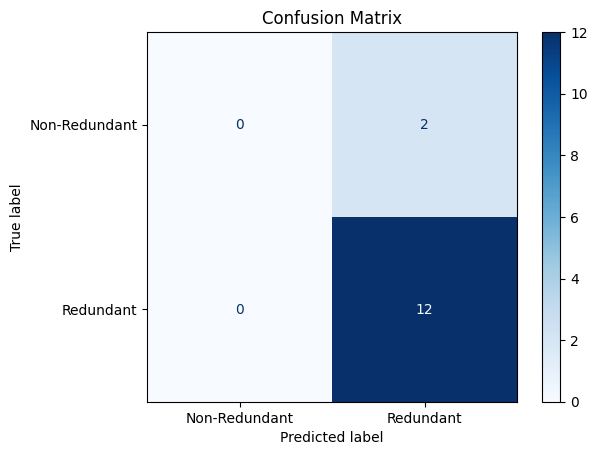

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


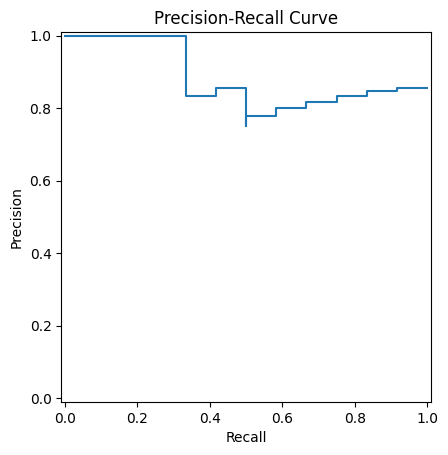

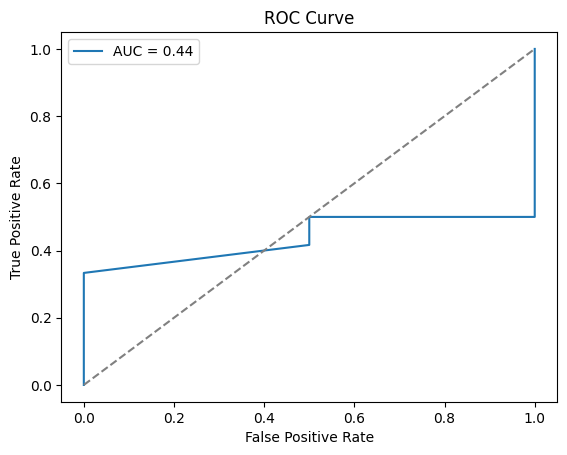

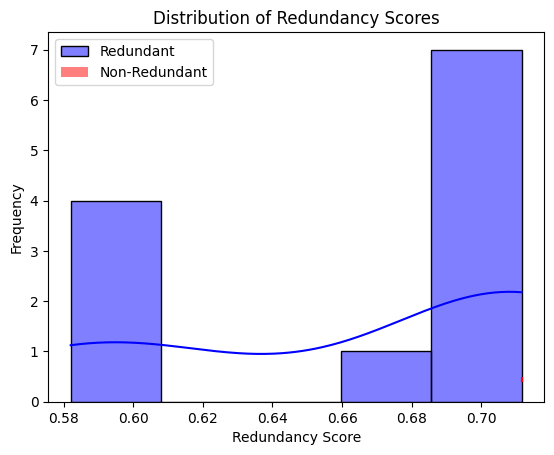

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


def main():
    # Load the dataset
    dataset = pd.read_json("/content/sample_data/redundancy_dataset.json")

    # Initialize the detector
    detector = CodeRedundancyDetector(dataset)

    # Build the model
    detector.build_model()

    # Train the model
    history = detector.train_model(epochs=10)  # Adjust epochs based on need

    # Evaluate the model
    detector.evaluate_model()

    # Example prediction
    original_code = """
    def process_data(data_list):
        result = []
        for item in data_list:
            if isinstance(item, (int, float)):
                result.append(item * 2)
            elif isinstance(item, str):
                result.append(item.upper())
            else:
                result.append(str(item))
        return result
    """
    comparison_code = """
    def transform_list(input_list):
        output = []
        for element in input_list:
            if type(element) in [int, float]:
                output.append(element * 2)
            elif type(element) == str:
                output.append(element.upper())
            else:
                output.append(str(element))
        return output
    """
    redundancy_score = detector.predict_redundancy(original_code, comparison_code)
    print(f"Redundancy Score: {redundancy_score}")
    if redundancy_score > 0.5:
        print("The code is redundant.")
    else:
        print("The code is not redundant.")

    # Get predictions on the test set
    y_pred = (detector.model.predict([detector.X1_test, detector.X2_test]) > 0.5).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(detector.y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Redundant', 'Redundant'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    # Get predicted probabilities
    y_scores = detector.model.predict([detector.X1_test, detector.X2_test]).ravel()
    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(detector.y_test, y_scores)
    # Display the Precision-Recall curve
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title("Precision-Recall Curve")
    plt.show()
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(detector.y_test, y_scores)
    # Calculate AUC
    auc_score = roc_auc_score(detector.y_test, y_scores)
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    # Plot redundancy scores for redundant and non-redundant classes
    sns.histplot(y_scores[detector.y_test == 1], color="blue", kde=True, label="Redundant")
    sns.histplot(y_scores[detector.y_test == 0], color="red", kde=True, label="Non-Redundant")
    plt.title("Distribution of Redundancy Scores")
    plt.xlabel("Redundancy Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
